In [11]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from models import VAE
import numpy as np
import glob
import random
import open3d as o3d
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [12]:
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--epochs", type=int, default=5000)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--learning_rate", type=float, default=0.0009)
parser.add_argument("--encoder_layer_sizes", type=list, default=[7500, 512])
parser.add_argument("--decoder_layer_sizes", type=list, default=[512, 7500])
parser.add_argument("--latent_size", type=int, default=2)
parser.add_argument("--print_every", type=int, default=100)
parser.add_argument("--fig_root", type=str, default='figs')
parser.add_argument("--conditional", default = True, action='store_true')

args = parser.parse_args(args=[])

In [13]:
def read_ply_file(file_path):
    if file_path.split('.')[-1]=='ply':
        pcd = o3d.io.read_point_cloud(file_path)
        points = np.asarray(pcd.points)
        return points
    else:
        DATA = pd.read_csv(file_path, delimiter = "\t", header=None)
        DATA = DATA.to_numpy()[:,:3]
        return DATA
        
def raddens_constV(radial_distances, bin_volume = 50000):
    maxbin = 500000
    limit = np.max(radial_distances)
#     print(f'limit is: {limit}')
    raddens = np.zeros((maxbin, 3))
    r1 = 0
    r2 = (bin_volume / ((4 / 3) * np.pi)) ** (1 / 3)
    bin = 0
    allvolume = bin_volume
    edges = np.zeros(maxbin + 1)
    r = r2
    # while r2 <= limit and bin < maxbin:
    while r2 <= 300:
        raddens[bin, 0] = (bin + 0.5) ** (1 / 3) * r
        raddens[bin, 1] = np.sum((radial_distances > r1) & (radial_distances <= r2)) / (
                bin_volume * 1e-27 * len(radial_distances))
        if bin >= maxbin:
            break
        bin += 1
        allvolume += bin_volume
        r1 = r2
        r2 = (allvolume / (np.pi * (4 / 3))) ** (1 / 3)
        edges[bin] = r1
    return edges[:bin]

def data_distribution(coordinates, bin_volume = 50000):
    center_point = np.mean(coordinates, axis=0)
    # Calculate distances
    radial_distances = np.linalg.norm(coordinates - center_point, axis=1)
    edges = raddens_constV(radial_distances, bin_volume)
    selected_points = []
    pointcount_intervals = []
    
    ## calculate number of points in each interval
    for i in range(len(edges) - 1):
        r1 = edges[i]
        r2 = edges[i + 1]       
        # Select original points within the specified interval
        selected_interval_points = coordinates[(radial_distances >= r1) & (radial_distances <= r2)]
        pointcount_intervals.append(len(selected_interval_points))
    pointcount_intervals = np.array(pointcount_intervals)
    pointcount_intervals = pointcount_intervals/max(pointcount_intervals)
    
    return pointcount_intervals


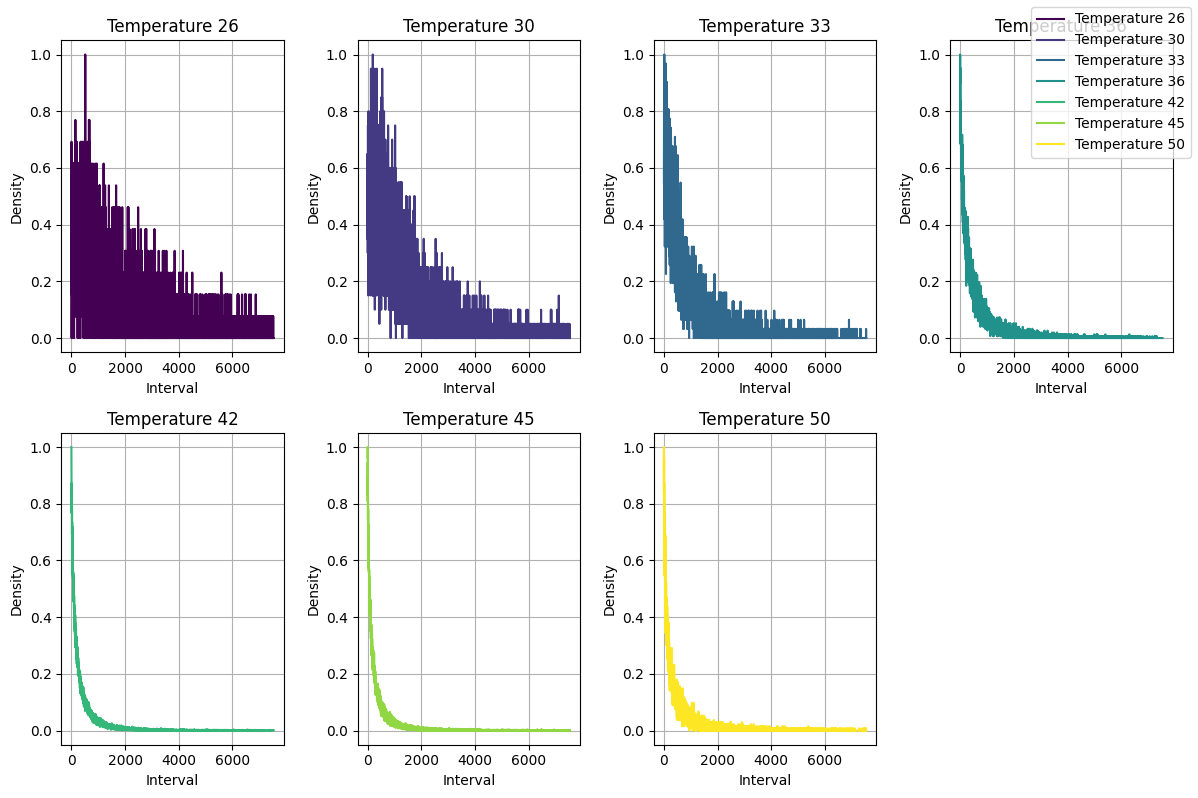

In [14]:
data_path = "../src2/pointcloud_dataset/"
temperatures = sorted(os.listdir(data_path))

# Create a single figure for all subplots
fig = plt.figure(figsize=(12, 8))

# Lists to store legends and corresponding handles
legends = []
handles = []

colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))

# Loop through each temperature and create a subplot for it
for i, (temp, color) in enumerate(zip(temperatures, colors), start=1):
    coordinates = []
    file_list = sorted(glob.glob(os.path.join(data_path,temp,'*.ply')))
    for id_sample, file_name in enumerate(file_list):
        points  = read_ply_file(file_name)  
        points = points-(np.mean(points, axis=0))     
        coordinates.extend(points)
    
    coordinates = np.array(coordinates)
    # coordinates  = read_ply_file(os.path.join(data_path, temp, '1.ply'))
    distribution = data_distribution(coordinates, bin_volume=15000)

    # Create a subplot
    ax = fig.add_subplot(2, 4, i)  # 2 rows, 4 columns, i-th subplot

    # Plot the density distribution for the current temperature and store the handle
    line, = ax.plot(range(1, len(distribution) + 1), distribution, marker='', color=color, linestyle='-')
    
    # Store the legend label and corresponding handle
    legends.append(f'Temperature {temp}')
    handles.append(line)

    # Add labels and title
    ax.set_xlabel('Interval')
    ax.set_ylabel('Density')
    ax.set_title(f'Temperature {temp}')

    # Add grid
    ax.grid()

# Add a legend to the figure
fig.legend(handles, legends, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [15]:
class PointCloudDataset(Dataset):
    def __init__(self, data_dir, classes=7, samples = 10, embed = 7500, bin_volume = 15000):
        self.data = []
        self.label = []
        self.data_dir = data_dir
        self.temperatures = sorted(os.listdir(data_dir))
        for id_class, temp in enumerate(self.temperatures, start=0):
            file_list = sorted(glob.glob(os.path.join(data_dir,temp,'*.ply')))
            coordinates = []
            for id_sample, file_name in enumerate(file_list):
                points  = read_ply_file(file_name)  
                points = points-(np.mean(points, axis=0))     
                coordinates.extend(points)
            coordinates = np.array(coordinates)
            distribution = data_distribution(coordinates, bin_volume=bin_volume)

            self.data.append(distribution[:embed])
            self.label.append(id_class)
        
        self.data = np.array(self.data)
        self.label = np.array(self.label)

        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.label = torch.tensor(self.label, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data  = self.data[idx]
        label = self.label[idx]

        return data, label

class PointCloudDataset_v2(Dataset):
    def __init__(self, data_dir, classes=7, samples = 10, embed = 7500, bin_volume = 15000):
        self.data = []
        self.label = []
        self.data_dir = data_dir
        self.temperatures = sorted(os.listdir(data_dir))
        for id_class, temp in enumerate(self.temperatures, start=0):
            for itter in range(10):
                file_list = sorted(glob.glob(os.path.join(data_dir,temp,'*.ply')))
                file_list.pop(itter)
                coordinates = []
                for id_sample, file_name in enumerate(file_list):
                    points  = read_ply_file(file_name)  
                    points = points-(np.mean(points, axis=0))     
                    coordinates.extend(points)
                coordinates = np.array(coordinates)
                distribution = data_distribution(coordinates, bin_volume=bin_volume)

                self.data.append(distribution[:embed])
                self.label.append(id_class)
        
        self.data = np.array(self.data)
        self.label = np.array(self.label)

        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.label = torch.tensor(self.label, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

class PointCloudDataset_v3(Dataset):
    def __init__(self, data_dir, train= True, classes=7, samples = 10, embed = 7500, bin_volume = 15000):
        self.data = []
        self.label = []
        self.n = 10
        self.data_dir = data_dir
        self.temperatures = sorted(os.listdir(data_dir))
        for id_class, temp in enumerate(self.temperatures, start=0):
            for itter in range(self.n):
                file_list = sorted(glob.glob(os.path.join(data_dir,temp,'*.ply')))
                file_list.pop(itter)
                coordinates = []
                for id_sample, file_name in enumerate(file_list):
                    points  = read_ply_file(file_name)  
                    points = points-(np.mean(points, axis=0))     
                    coordinates.extend(points)
                coordinates = np.array(coordinates)
                distribution = data_distribution(coordinates, bin_volume=bin_volume)

                self.data.append(distribution[:embed])
                self.label.append(id_class)
        
        N = int(len(self.data)*0.8)
        
        if train:
            self.data = np.array(self.data[:N])
            self.label = np.array(self.label[:N])
        else:
            self.data = np.array(self.data[N:])
            self.label = np.array(self.label[N:])

        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.label = torch.tensor(self.label, dtype=torch.int64)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data  = self.data[idx]
        label = self.label[idx]

        return data, label

data_path = "../src2/pointcloud_dataset/"
dataset_tr = PointCloudDataset_v3(data_path, train= True)
dataset_va = PointCloudDataset_v3(data_path, train= False)


label 2
label 2
label 2
label 1
label 4
label 3
label 5
label 0


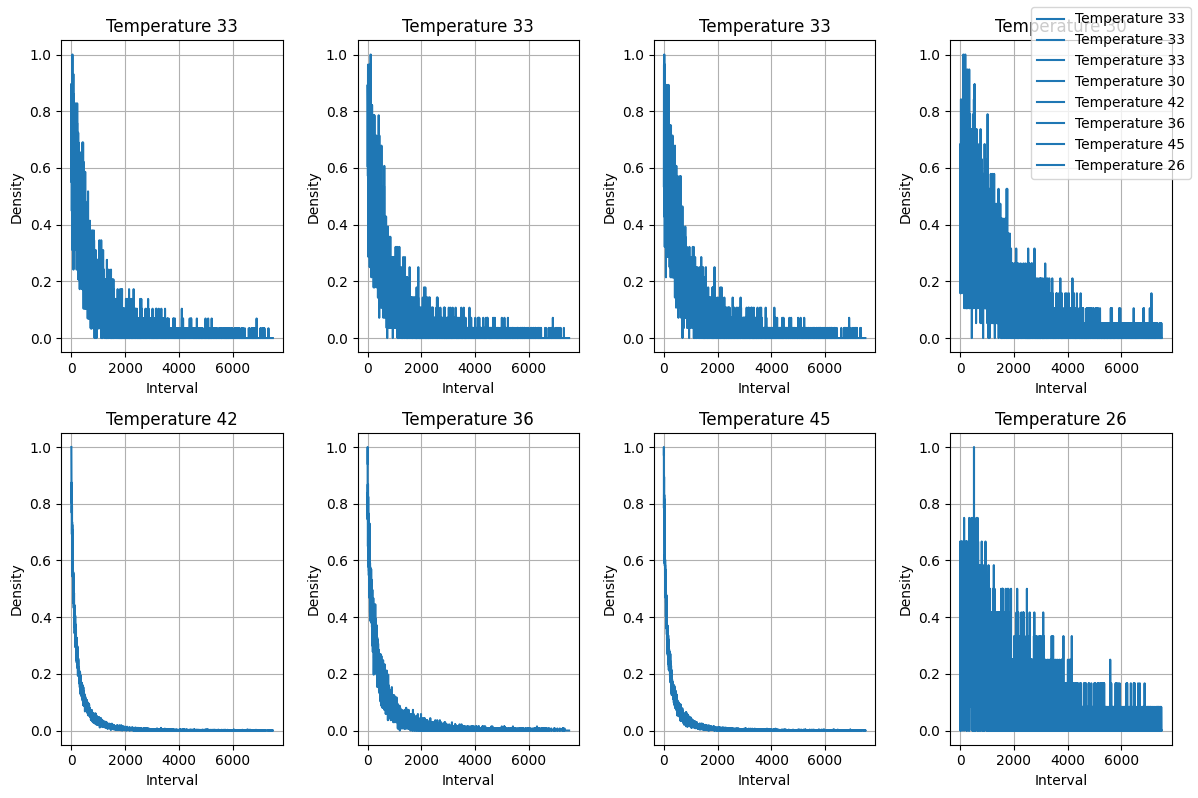

In [16]:
# Define batch size
batch_size = 1

# Create a data loader for the dataset
dataloader = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)

fig = plt.figure(figsize=(12, 8))

# Lists to store legends and corresponding handles
legends = []
handles = []

colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))

# Loop through each temperature and create a subplot for it
for i, (x, y) in enumerate(dataloader):
    distribution, label = x[0], y[0]
    # Create a subplot
    ax = fig.add_subplot(2, 4, i+1)  # 2 rows, 4 columns, i-th subplot

    # Plot the density distribution for the current temperature and store the handle
    line, = ax.plot(range(1, len(distribution) + 1), distribution, marker='', linestyle='-')
    print(f'label {label}')
    # Store the legend label and corresponding handle
    legends.append(f'Temperature {temperatures[label]}')
    handles.append(line)

    # Add labels and title
    ax.set_xlabel('Interval')
    ax.set_ylabel('Density')
    ax.set_title(f'Temperature {temperatures[label]}')

    # Add grid
    ax.grid()
    if i>=7:
        break


# Add a legend to the figure
fig.legend(handles, legends, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [17]:
# Define batch size
batch_size = 7
dataset_tr = PointCloudDataset_v3(data_path, train= True)
dataset_va = PointCloudDataset_v3(data_path, train= False)

# Create a data loader for the dataset
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_va = DataLoader(dataset_va, batch_size=1)



In [18]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = time.time()

## Loss functions
def mse_loss_fn(recon_x, x):
    # Calculate the mean squared error loss
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    return mse_loss

def l1_loss_fn(recon_x, x):
    # Calculate the L1 loss
    l1_loss = F.l1_loss(recon_x, x, reduction='sum')
    
    return l1_loss

def smooth_l1_loss_fn(recon_x, x):
    # Calculate the smooth L1 loss (Huber loss)
    smooth_l1_loss = F.smooth_l1_loss(recon_x, x, reduction='sum')
    
    return smooth_l1_loss

def loss_fn(recon_x, x, mean, log_var, mode = "mse"):
    if mode == "L1smooth":
        RCL = smooth_l1_loss_fn(recon_x, x)
    elif mode == "mse":
        RCL = mse_loss_fn(recon_x, x)
    else:
        RCL = l1_loss_fn(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (RCL + KLD) / x.size(0)

vae = VAE(
encoder_layer_sizes=args.encoder_layer_sizes,
latent_size=args.latent_size,
decoder_layer_sizes=args.decoder_layer_sizes,
conditional=args.conditional,
num_labels=7 if args.conditional else 0).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=args.learning_rate)

logs = defaultdict(list)

In [10]:
best_loss = np.inf
for epoch in range(args.epochs):

    tracker_epoch = defaultdict(lambda: defaultdict(dict))
    ep_loss = 0.0
    for iteration, (x, y) in enumerate(dataloader_tr):

        x, y = x.to(device), y.to(device)

        if args.conditional:
            recon_x, mean, log_var, z = vae(x, y)
        else:
            recon_x, mean, log_var, z = vae(x)

        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())
        ep_loss += loss.item()

        if iteration % args.print_every == 0 or iteration == len(dataloader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                epoch, args.epochs, iteration, len(dataloader)-1, loss.item()))
    ep_loss = ep_loss/(iteration+1)
    if ep_loss<best_loss:
        torch.save(vae.state_dict(), 'model_weightscvae.pth')
        best_loss = ep_loss
    


Epoch 00/5000 Batch 0000/0, Loss 1620.3510
Epoch 01/5000 Batch 0000/0, Loss 1499.9973
Epoch 02/5000 Batch 0000/0, Loss 1307.9614
Epoch 03/5000 Batch 0000/0, Loss 1095.6401
Epoch 04/5000 Batch 0000/0, Loss  822.1315
Epoch 05/5000 Batch 0000/0, Loss  574.9433
Epoch 06/5000 Batch 0000/0, Loss  426.8324
Epoch 07/5000 Batch 0000/0, Loss  297.5686
Epoch 08/5000 Batch 0000/0, Loss  252.1824
Epoch 09/5000 Batch 0000/0, Loss  242.6459
Epoch 10/5000 Batch 0000/0, Loss  247.7134
Epoch 11/5000 Batch 0000/0, Loss  246.7731
Epoch 12/5000 Batch 0000/0, Loss  244.1899
Epoch 13/5000 Batch 0000/0, Loss  234.0631
Epoch 14/5000 Batch 0000/0, Loss  220.0955
Epoch 15/5000 Batch 0000/0, Loss  203.8190
Epoch 16/5000 Batch 0000/0, Loss  186.2762
Epoch 17/5000 Batch 0000/0, Loss  168.2969
Epoch 18/5000 Batch 0000/0, Loss  150.3333
Epoch 19/5000 Batch 0000/0, Loss  135.1115
Epoch 20/5000 Batch 0000/0, Loss  120.3168
Epoch 21/5000 Batch 0000/0, Loss  106.6915
Epoch 22/5000 Batch 0000/0, Loss   95.4771
Epoch 23/50

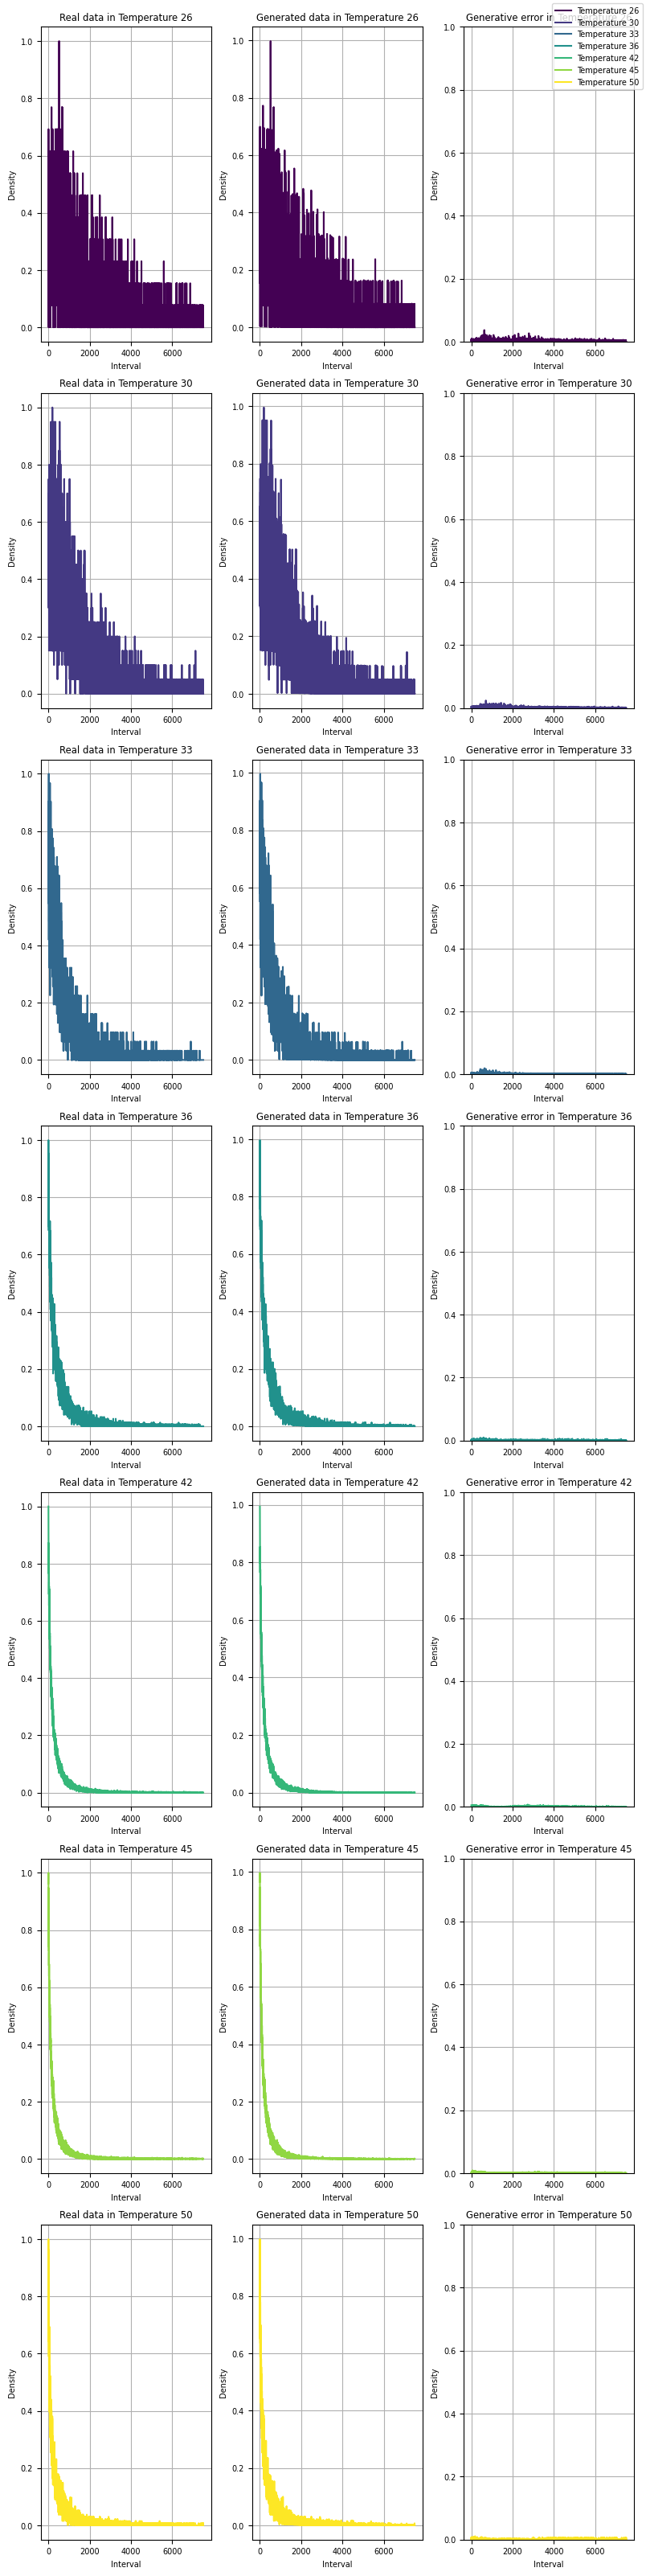

In [11]:
c = torch.arange(0, 7).long().unsqueeze(1).to(device)
z = torch.randn([c.size(0), args.latent_size]).to(device)
generated = vae.inference(z, c=c)
generated = generated.detach().cpu().numpy()

data_path = "pointcloud_dataset/"
temperatures = sorted(os.listdir(data_path))

# Create a single figure for all subplots
fig = plt.figure(figsize=(8,32))
# Set the default font size for all text elements
import matplotlib as mpl
mpl.rcParams['font.size'] = 7

# Lists to store legends and corresponding handles
legends = []
handles = []

colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))


# Loop through each temperature and create a subplot for it
for i, (temp, color) in enumerate(zip(temperatures, colors), start=0):
    coordinates = []
    file_list = sorted(glob.glob(os.path.join(data_path,temp,'*.ply')))
    for id_sample, file_name in enumerate(file_list):
        points  = read_ply_file(file_name)  
        points = points-(np.mean(points, axis=0))     
        coordinates.extend(points)
    
    coordinates = np.array(coordinates)
    # coordinates  = read_ply_file(os.path.join(data_path, temp, '1.ply'))
    distribution = data_distribution(coordinates, bin_volume=15000)
    distribution = distribution[:7500]
    distribution_generated = generated[i]

    # Create a subplot
    ax = fig.add_subplot(7, 3, i*3+1)  # 2 rows, 4 columns, i-th subplot

    # Plot the density distribution for the current temperature and store the handle
    line, = ax.plot(range(1, len(distribution) + 1), distribution, marker='', color=color, linestyle='-')
    
    # Store the legend label and corresponding handle
    # legends.append(f'Temperature {temp}')
    # handles.append(line)

    # Add labels and title
    ax.set_xlabel('Interval')
    ax.set_ylabel('Density')
    ax.set_title(f'Real data in Temperature {temp}')
    # Add grid
    ax.grid()
    ########################################################## Generated data ####################################
    ax = fig.add_subplot(7, 3, i*3+2)  # 2 rows, 4 columns, i-th subplot

    # Plot the density distribution for the current temperature and store the handle
    line, = ax.plot(range(1, len(distribution_generated) + 1), distribution_generated, marker='', color=color, linestyle='-')
    
    # Store the legend label and corresponding handle
    # legends.append(f'Temperature {temp}')
    # handles.append(line)

    # Add labels and title
    ax.set_xlabel('Interval')
    ax.set_ylabel('Density')
    ax.set_title(f'Generated data in Temperature {temp}')


    # Add grid
    ax.grid()

    ########################################################## Error rate ####################################
    ax = fig.add_subplot(7, 3, i*3+3)  # 2 rows, 4 columns, i-th subplot

    # Plot the density distribution for the current temperature and store the handle
    line, = ax.plot(range(1, len(distribution_generated) + 1), abs(distribution-distribution_generated), marker='', color=color, linestyle='-')
    
    # Store the legend label and corresponding handle
    legends.append(f'Temperature {temp}')
    handles.append(line)

    # Add labels and title
    ax.set_xlabel('Interval')
    ax.set_ylabel('Density')
    ax.set_title(f'Generative error in Temperature {temp}')

    # Add grid
    ax.grid()
    # Set y-axis limits from 0 to 1
    ax.set_ylim(0, 1)


# Add a legend to the figure
fig.legend(handles, legends, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()




In [12]:
samples_real = []
temperatures = sorted(os.listdir(data_path))
for id_class, temp in enumerate(temperatures, start=0):
    file_list = sorted(glob.glob(os.path.join(data_path, temp,'*.ply')))
    coordinates = []
    for id_sample, file_name in enumerate(file_list):
        points  = read_ply_file(file_name)  
        points = points-(np.mean(points, axis=0))     
        coordinates.extend(points)
        
    coordinates = np.array(coordinates)
    samples_real.append(coordinates)
 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
generated_features = [] # features we generated from the VAE model and want to use for generating pointcloud
gt = samples_real # master samples 

for i, (x, y) in enumerate(dataloader):
    distribution_data, label = x[0], y[0]
    distribution_data_norm = distribution_data/max(distribution_data)
    generated_features.append(distribution_data_norm)

class PointCloudGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PointCloudGenerator, self).__init__()
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 3 * output_dim)  # Output: x, y, z for each point

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, self.output_dim, 3)

generated_point_cloud = []
models = []
for idx in range(len(samples_real)):
    ## Create models
    model = PointCloudGenerator(generated_features[idx].shape[0], gt[idx].shape[0])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(torch.tensor(generated_features[idx]).float())

        # Compute loss
        loss = criterion(outputs, torch.tensor(gt[idx]).float())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Generate point clouds using the trained model
    with torch.no_grad():
        generated_point_cloud.append(model(torch.tensor(generated_features[idx])))
    models.append(model)


Epoch [100/1000], Loss: 50.9681
Epoch [200/1000], Loss: 2.8347
Epoch [300/1000], Loss: 0.1407
Epoch [400/1000], Loss: 0.0048
Epoch [500/1000], Loss: 0.0004
Epoch [600/1000], Loss: 0.0005
Epoch [700/1000], Loss: 0.0004
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0006
Epoch [1000/1000], Loss: 0.0006
Epoch [100/1000], Loss: 97.8957
Epoch [200/1000], Loss: 2.2277
Epoch [300/1000], Loss: 0.0171
Epoch [400/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0010
Epoch [700/1000], Loss: 0.0012
Epoch [800/1000], Loss: 0.0013
Epoch [900/1000], Loss: 0.0013
Epoch [1000/1000], Loss: 0.0017
Epoch [100/1000], Loss: 91.1519
Epoch [200/1000], Loss: 13.5371
Epoch [300/1000], Loss: 0.8314
Epoch [400/1000], Loss: 0.0264
Epoch [500/1000], Loss: 0.0011
Epoch [600/1000], Loss: 0.0005
Epoch [700/1000], Loss: 0.0005
Epoch [800/1000], Loss: 0.0004
Epoch [900/1000], Loss: 0.0006
Epoch [1000/1000], Loss: 0.0006
Epoch [100/1000], Loss: 74.8105
Epoch [200/1000], Loss: 21.6027

In [ ]:
def sort_points_by_distance(pointcloud):
    # Calculate the center of the point cloud
    center = np.mean(pointcloud, axis=0)

    # Calculate the distances of each point from the center
    distances = np.linalg.norm(pointcloud - center, axis=1)

    # Get the indices that would sort the distances
    sorted_indices = np.argsort(distances)

    # Sort the point cloud based on the distances
    sorted_pointcloud = pointcloud[sorted_indices]

    return sorted_pointcloud

def select_samples(sorted_pointcloud, num_samples = 1000):
    # Calculate the number of points and intervals
    num_points = len(sorted_pointcloud)
    interval_size = num_points // num_samples

    # Initialize the selected samples list
    selected_samples = []

    # Randomly select one point from each interval
    for i in range(0, num_points, interval_size):
        interval_end = min(i + interval_size, num_points)
        selected_index = np.random.randint(i, interval_end)
        selected_samples.append(sorted_pointcloud[selected_index])

    return np.array(selected_samples)

In [17]:
len(generated_features)

1